# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment
### Install spp client to your local device: 
`pip install -i https://pip.s2.allenai.org/simple spp_client==0.1.0`

### Then install an upgraded version of MMDA:  
`pip install -i https://pip.s2.allenai.org/simple mmda==0.3.5`

## 1. Get data from annotation store via spp_client

### 1a. Get and set sources
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [1]:
####################################################################
# ANNOTATOR TODO: change this to sha you're analyzing
####################################################################

#This sha will get overwritten when running autogenerater script
sha = 'd17961483e3eb55df82cc16a01d4519af1b4dbbd'


In [2]:
# SPP version for Eval Sample
spp_version = "dag-0.0.4"

In [3]:
# See step 0 -- should have MMDA version 0.3.5
! pip show mmda

Name: mmda
Version: 0.3.5
Summary: MMDA - multimodal document analysis
Home-page: 
Author: 
Author-email: Allen Institute for Artificial Intelligence <contact@allenai.org>
License: Apache-2.0
Location: /Users/angelez/.pyenv/versions/3.9.0/envs/mmda_recipes/lib/python3.9/site-packages
Requires: ncls, necessary, pandas, pdf2image, pdfplumber, pydantic, requests, tqdm
Required-by: spp-client


### 1b. Retrieve Annotations
Using the sources obtained from the previous cell, we will now retreive the annotations for each source via spp_client.

In [4]:
# Get annotations and data as text using spp client
from spp_client.client import (
    mmda_span_group_to_text_via_dwp_words,
    RelationTypeId,
    SppClient,
)
client = SppClient.mk(env="dev")

mmda_doc, relations = client.get_document(
            sha,
            spp_version,
            annotation_types=[
                "pages",
                "tokens",
                "rows",
                "bib_entries",
                "citation_mentions",
                "bib_entry_titles",
                "bib_entry_dois",
                "bib_entry_years",
                "words"
            ],
            relation_types=[
                RelationTypeId("refers_to", "citation_mentions", "bib_entries")
            ],
            allow_missing=True,
            include_images=True
        )


/Users/angelez/.pyenv/versions/mmda_recipes/lib/python3.9/site-packages/mmda/types/document.py:79: UserWarning: The annotations is empty for the field bib_entry_dois
  warnings.warn(f"The annotations is empty for the field {field_name}")


In [5]:
print(mmda_doc.fields)

if 'bib_entries' not in mmda_doc.fields:
    print("No bib_entries!")

['bib_entry_years', 'citation_mentions', 'bib_entry_titles', 'words', 'tokens', 'rows', 'bib_entry_dois', 'bib_entries', 'pages']


## 2. Visalize Mentions (draw boxes)
Use draw_boxes to visualize each mention.

### 2a. Make Layout Rectangles for mentions so that vizes can be made for them.

In [6]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_by_page = defaultdict(list)
    original_boxes_by_page = defaultdict(list)
    
    for mention in mmda_doc.citation_mentions:
        for box in mention.box_group.boxes:
            original_boxes_by_page[box.page].append(box) 
            
    #mapping between pages and spans on page
    for page, list_of_boxes in original_boxes_by_page.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_by_page[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_by_page

## 3. Get references and s2 id's for each mention.

### 3a. Retreive citation mention numbers and which bib entries they are linked to.

In [7]:
# ie: for citation_mention '0', the bib_entry_id it's linked to is '3'. 
citation_links = defaultdict(int)

for relation in relations[list(relations.keys())[0]]:
    #add to list of citation link data
    citation_links[relation.from_id] = relation.to_id

### 3b. Use API call to find what s2 paper each bib entry is linked to.

In [8]:
def get_index_of_bib_entry_with_id(bib_entry_id):
    linked_bib_entry_index_list = [i for i, bib_entry in enumerate(mmda_doc.bib_entries) if bib_entry.id == bib_entry_id]
    assert len(linked_bib_entry_index_list) == 1, f"there should be exactly one bib_entry with the id {bib_entry_id}."
    return linked_bib_entry_index_list[0]

def extract_first_group_symbols(span_groups):
    if len(span_groups) > 1:
        print("warning: multiple span_groups detected when 0 or 1 expected")
    try: 
        first_one = span_groups[0] 
        text = mmda_span_group_to_text_via_dwp_words(first_one)
    except IndexError: # case where was no annotation detected so span_groups was empty list
            text = "" # it can be empty or say "no text detected" or something
    return text

def extract_first_group_symbols_no_dwp(span_groups):
    if len(span_groups) > 1:
        print("warning: multiple span_groups detected when 0 or 1 expected")
    try: 
        first_one = span_groups[0] 
        text = mmda_span_group_to_text_via_dwp_words(first_one)
    except IndexError: # case where was no annotation detected so span_groups was empty list
            text = "" # it can be empty or say "no text detected" or something
    return text


def get_bib_entry_title(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    # print("linked_bib_id: ", linked_bib_id)
    # Accessing the linked bib_entry this way is error-prone because MMDA annotations can't be assumed to be sorted by SpanGroup IDs
    # bib_title_span_groups = mmda_doc.bib_entries[linked_bib_id].bib_entry_titles 
    # We have to find the correct bib_entry this way:
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)
    if len(mmda_doc.bib_entry_titles) == 0:
        return None
    bib_title_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_titles 
    text_words = extract_first_group_symbols(bib_title_span_groups)
    if text_words == "":
         text_words = None

    return text_words

def get_bib_entry_year(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)
    if len(mmda_doc.bib_entry_years) == 0:
        return None
    bib_year_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_years 
    text_symbols = extract_first_group_symbols_no_dwp(bib_year_span_groups)
    try:
        year = int(text_symbols)
    except:
        # If the year fails to be mapped to integer, default to None
        year = None

    return year

def get_bib_entry_doi(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)
    if len(mmda_doc.bib_entry_dois) == 0:
         return None
    bib_doi_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_dois 
    text_symbols = extract_first_group_symbols_no_dwp(bib_doi_span_groups)
    if text_symbols == "":
         text_symbols = None
    return text_symbols

def get_full_bib_entry_text(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)

    bib_span_groups = [mmda_doc.bib_entries[linked_bib_index]]
    text_symbols = extract_first_group_symbols(bib_span_groups)

    return text_symbols

In [9]:
#make api call to get linked papers
import json
import requests

def make_payload(mention_id):
    payload = dict()
    # make payload similar to how s2matchmaker does
    # https://github.com/allenai/s2matchmaker/blob/a88bc1415cc28c0e4c644e5394529229db0a9c13/s2matchmaker/model/bib_entry_info.py#L32
    title = get_bib_entry_title(mention_id) # make sure exists -- if no title then no payload
    if not title:
        return payload
    # optional attributes will have None value in the payload even it is missing from the attributes
    year = get_bib_entry_year(mention_id) # make sure is int, no dwp
    doi = get_bib_entry_doi(mention_id) # no dwp 
    
    payload.update({'title': title, 'year': year, 'doi': doi})

    return payload


def bibLinkingApiPost(payload, end_point='http://pipeline-api.prod.s2.allenai.org/citation/match'):
    payload_str = json.dumps([payload])
    headers = {
        'Content-Type': 'application/json'
    }
    response = requests.request("POST", end_point, headers=headers, data=payload_str).json()
    return response



# get s2_ids linked to each mention
s2_ids = []
for citation_mention in mmda_doc.citation_mentions:
    payload = make_payload(citation_mention.id)
    if not payload:
        s2_ids.append(-1)
        continue
    matched_s2_id = str((bibLinkingApiPost(payload))).replace('[', '').replace(']', '')
    s2_ids.append(matched_s2_id)

## 4. Annotation Info!

In [10]:
####################################################################
# ANNOTATOR TODO: Record page # from output in annotation spreadsheet
####################################################################

# get random page number to review and annotate
import random

pages_w_mentions = [citation_mention.pages[0].id for citation_mention in mmda_doc.citation_mentions]

annot_page = random.choice(pages_w_mentions)
print("page to annotate:", annot_page)

page to annotate: 19


In [11]:
# gives table of SPP mentions and their corresponding bib_entry ids 
# (if the doc is annotated with bib_entries), and s2 linked papers 
import pandas as pd
from IPython.display import HTML

if 'bib_entries' in mmda_doc.fields:
    ref_info = {
        # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
        "Page": [citation_mention.pages[0].id for citation_mention in mmda_doc.citation_mentions],
        "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
        # Bib entry and title texts are DWP "words".texts
        "Linked Bib Entry Extracted Text": [get_full_bib_entry_text(citation_mention.id) for citation_mention in mmda_doc.citation_mentions],    
        "Linked Bib Entry Title": [get_bib_entry_title(citation_mention.id) for citation_mention in mmda_doc.citation_mentions],    
        # "Linked Bib id": [citation_links[citation_mention.id] for citation_mention in mmda_doc.citation_mentions],
        "S2 id:": [ids if ids != str(-1) else " " for ids in s2_ids],
        "S2 url": [f"http://api.semanticscholar.org/corpusid:{ids}" if ids != str(-1) else " " for ids in s2_ids]
        }
else:
    ref_info = {
        # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
        "Page": [citation_mention.pages[0].id for citation_mention in mmda_doc.citation_mentions],
        "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
        # TODO: use DWP "words" text instead of doc.symbols (ex: the title "Reaction-Diﬀusion processes and meta-population mod-\nels in Heterogeneous Networks" gives no match, but manually changing "mod-\nels" to "models" results in an S2 id match)
        "Linked Bib Entry Title": ["no bibs" for citation_mention in mmda_doc.citation_mentions],    
        "Linked Bib Entry Extracted Text": ["no bibs" for citation_mention in mmda_doc.citation_mentions],    
        "S2 id:": ["no bibs" for ids in s2_ids],
        "S2 url": ["no bibs" for ids in s2_ids]
        }

spp_df = pd.DataFrame.from_dict(ref_info, orient='index')
spp_df = spp_df.transpose()

# selecting rows based on random page selected to annotate
# you can comment the line below out to see all mentions across all pages
spp_df = spp_df[spp_df['Page'] == annot_page]


# make s2 links clickable
print("SPP:")
HTML(spp_df.to_html(render_links=True, escape=False))

SPP:


,Page,Mention text,Linked Bib Entry Extracted Text,Linked Bib Entry Title,S2 id:,S2 url
81,19,[38],"(38) Venkateswaran, P.; Marshall, A.; Seitzman, J.; Lieuwen, T. Scaling turbulent ﬂame speeds of negative Markstein length fuel blends using leading points concepts. Combustion and Flame 2015 , 162 , 375–387.",Scaling turbulent ﬂame speeds of negative Markstein length fuel blends using leading points concepts,95059280,http://api.semanticscholar.org/corpusid:95059280
82,19,[37],"(37) Daniele, S.; Jansohn, P.; Mantzaras, J.; Boulouchos, K. Turbulent ﬂame speed for syngas at gas turbine relevant conditions. Proceedings of the Combustion Institute 2011 , 33 , 2937–2944.",Turbulent ﬂame speed for syngas at gas turbine relevant conditions,93860438,http://api.semanticscholar.org/corpusid:93860438
83,19,[4],"(4) Venkateswaran, P.; Marshall, A.; Shin, D. H.; Noble, D.; Seitzman, J.; Lieuwen, T. Measurements and analysis of turbulent consumption speeds of H2/CO mixtures. Combustion and Flame 2011 , 158 , 1602–1614.",Measurements and analysis of turbulent consumption speeds of H2/CO mixtures,98118876,http://api.semanticscholar.org/corpusid:98118876
84,19,[15],"(15) Venkateswaran, P.; Marshall, A.; Seitzman, J.; Lieuwen, T. Scaling turbulent ﬂame speeds of negative Markstein length fuel blends using leading points concepts. Combustion and Flame 2015 , 162 , 375–387.",Scaling turbulent ﬂame speeds of negative Markstein length fuel blends using leading points concepts,95059280,http://api.semanticscholar.org/corpusid:95059280
85,19,[36],"(36) Kobayashi, H.; Seyama, K.; Hagiwara, H.; Ogami, Y.; Aldredge, R. Burning velocity correlation of methane/air turbulent premixed ﬂames at high pressure and high temperature. Proceedings of the Combustion Institute 2005 , 30 , 827–834.",Burning velocity correlation of methane/air turbulent premixed ﬂames at high pressure and high temperature,93763356,http://api.semanticscholar.org/corpusid:93763356
86,19,[33],"(33) Sun, C. J.; Sung, C. J.; He, L.; Law, C. K. Dynamics of Weakly Stretched Flames: Quantitative Description and Extraction of Global Flame Parameters. Combust. Flame 1999 , 118 , 108–128.",Dynamics of Weakly Stretched Flames: Quantitative Description and Extraction of Global Flame Parameters,95513238,http://api.semanticscholar.org/corpusid:95513238
87,19,[32],"(32) Goodwin, D. G.; Moﬀat, H., K.; Speth, R. L. Cantera: An Object-oriented Software Toolkit for Chemical Kinetics, Thermodynamics, and Transport Processes. 2017; http: //www.cantera.org .","Cantera: An Object-oriented Software Toolkit for Chemical Kinetics, Thermodynamics, and Transport Processes",86382900,http://api.semanticscholar.org/corpusid:86382900
88,19,[30],"(30) Wang, H.; Xu, R.; Wang, K.; Bowman, C. T.; Hanson, R. K.; Davidson, D. F.; Brezin-sky, K.; Egolfopoulos, F. N. A physics-based approach to modeling real-fuel combustion chemistry - I. Evidence from experiments, and thermodynamic, chemical kinetic and statistical considerations. Combustion and Flame 2018 , 193 , 502–519.","A physics-based approach to modeling real-fuel combustion chemistry - I. Evidence from experiments, and thermodynamic, chemical kinetic and statistical considerations",103594219,http://api.semanticscholar.org/corpusid:103594219
89,19,[31],"(31) Xu, R. et al. A physics-based approach to modeling real-fuel combustion chemistry–II. Reaction kinetic models of jet and rocket fuels. Combustion and Flame 2018 , 193 , 520–537.",A physics-based approach to modeling real-fuel combustion chemistry–II. Reaction kinetic models of jet and rocket fuels,103334038,http://api.semanticscholar.org/corpusid:103334038
90,19,[29],"(29) Wang, K.; Xu, R.; Parise, T.; Shao, J.; Movaghar, A.; Lee, D. J.; Park, J.-W.; Gao, Y.; Lu, T.; Egolfopoulos, F. N.; Davidson, D. F.; Hanson, R. K.; Bowman, C. T.; Wang, H. A physics-based approach to modeling real-fuel combustion chemistry – IV. HyChem modeling of combustion kinetics of a bio-derived jet fuel and its blends with a conventional Je

In [12]:
#egor version
def draw_boxgroups(image, rectangle_list, color_map=None, id_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle,
                                 type=f'color_1'
                                )
                  )

    if image:
        return lpv.draw_box(image,
                            viz,
                            color_map=color_map,
                            show_element_id=False,
                            id_font_size=10)
    
    return None

annotation page:  19


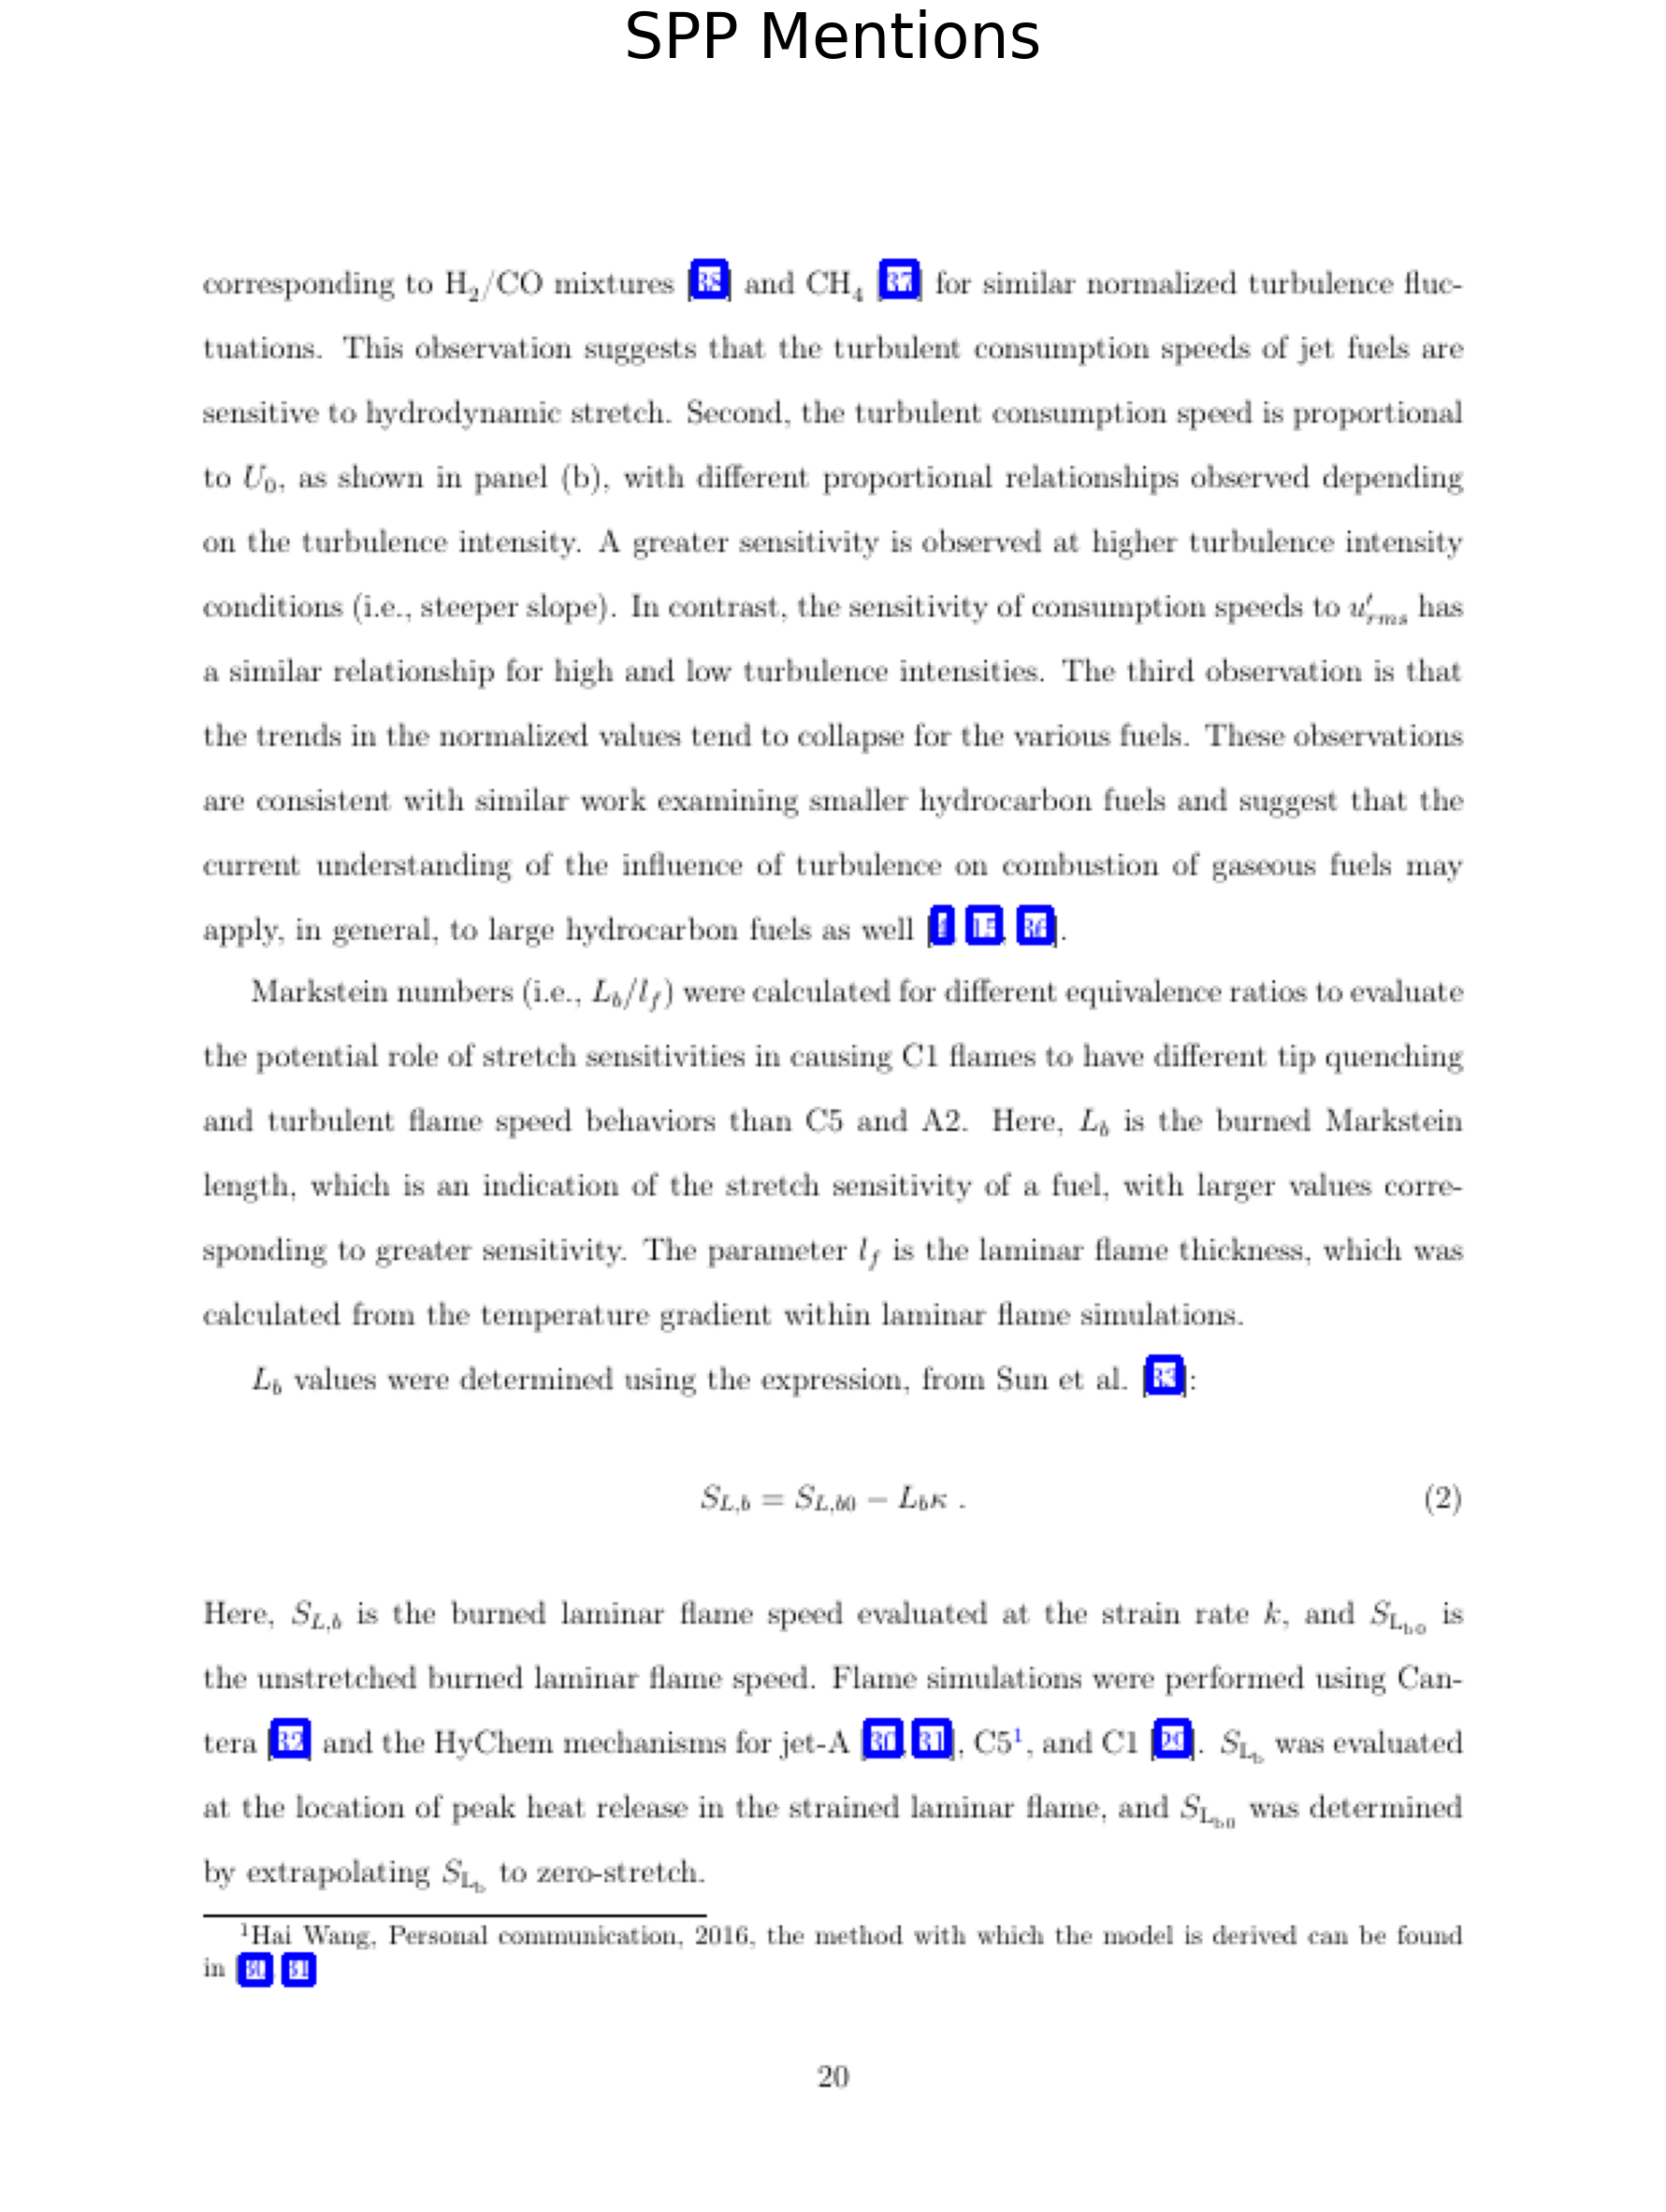

In [13]:
# mentions imgs
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


rows = 1
columns = 2
fontsize = 48

print("annotation page: ", annot_page)

#spp
#make boxes and save as image
boxes_by_page = make_boxgroups_mentions(mmda_doc)
image1 = draw_boxgroups(mmda_doc.images[annot_page], boxes_by_page[annot_page])

#plot
fig = plt.figure(figsize=(50, 50))
fig.add_subplot(rows, columns, 1)
plt.axis('off')
plt.title("SPP Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image1)


In [14]:
# View all mentions
# uncomment below to see all pages that have mentions (not just the selected annotation page)

# print("annotation page: ", annot_page)

# for page in boxes_by_page:
#     print(f"page {page}:")
#     display(draw_boxgroups(mmda_doc.images[page], boxes_by_page[page]))

In [15]:
def draw_text_blocks(page, text_blocks_dictionary, color_map=None, id_map=None):
    image = mmda_doc.images[page]

    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    if image:
        return lpv.draw_box(image,
                            text_blocks_dictionary[page],
                            color_map=color_map,
                            show_element_id=True,
                            id_font_size=10
                            # id_text_background_alpha=0.2
                            )
    
    return None

#function to create labeled text blocks from grobid bibs on the mmda doc
def make_text_blocks_bibs(mmda_doc):

    result_text_blocks_list = defaultdict(list)
    dictionary_of_box_groups = defaultdict(list)
    
    for bib in mmda_doc.bib_entries:
        # it's always 1 box
        dictionary_of_box_groups[bib.box_group.boxes[0].page].append(bib.box_group)
    
    #mapping between pages and spans on page
    for page, box_groups in dictionary_of_box_groups.items():
        page_w, page_h = mmda_doc.images[page].size

        for box_group in box_groups:
            # it's always 1 box
            box = box_group.boxes[0]
            rect = lpe.Rectangle(
                    box.l * page_w,
                    box.t * page_h,
                    (box.l + box.w) * page_w,
                    (box.t + box.h) * page_h
                )
            result_text_blocks_list[page].append(lpe.TextBlock(
                rect,
                id=box_group.id,
                type='color_1'
            ))
    return result_text_blocks_list

### SPP Bibs Pages

SPP
bib_pages [23, 24, 25, 26, 27, 28]
page 23:


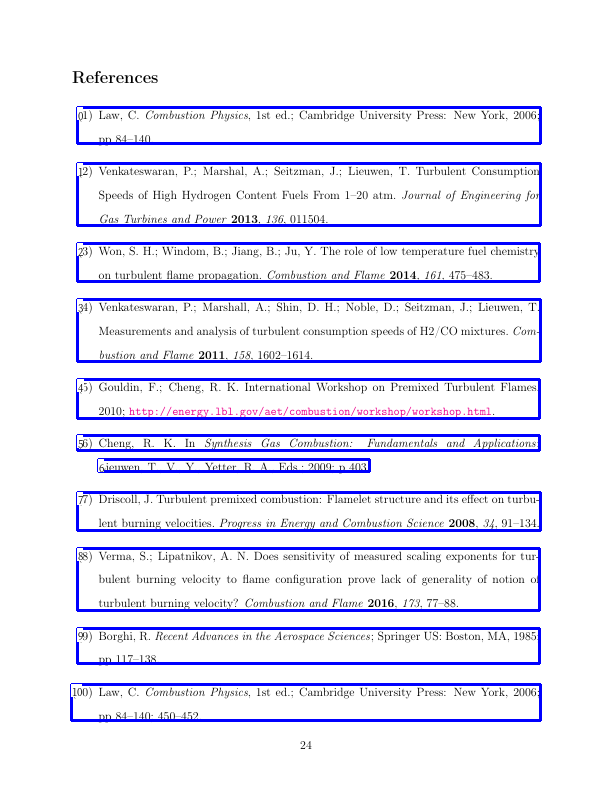

page 24:


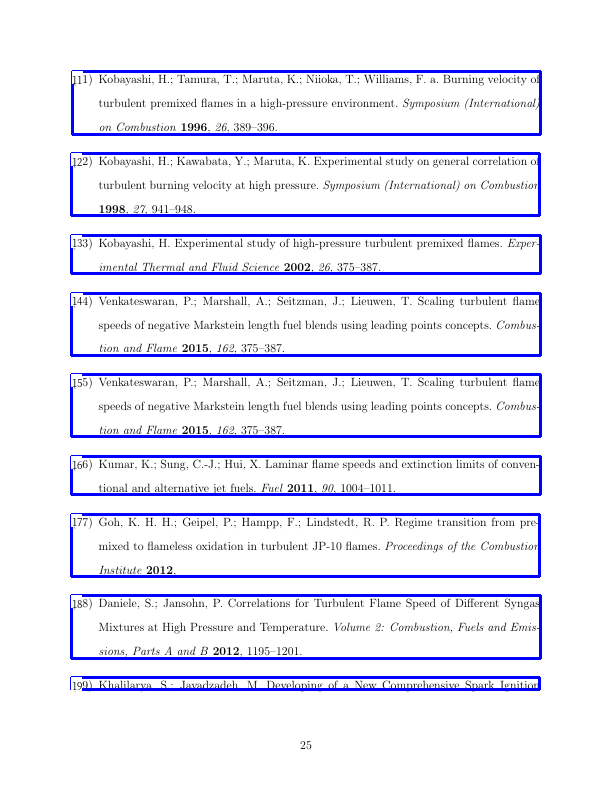

page 25:


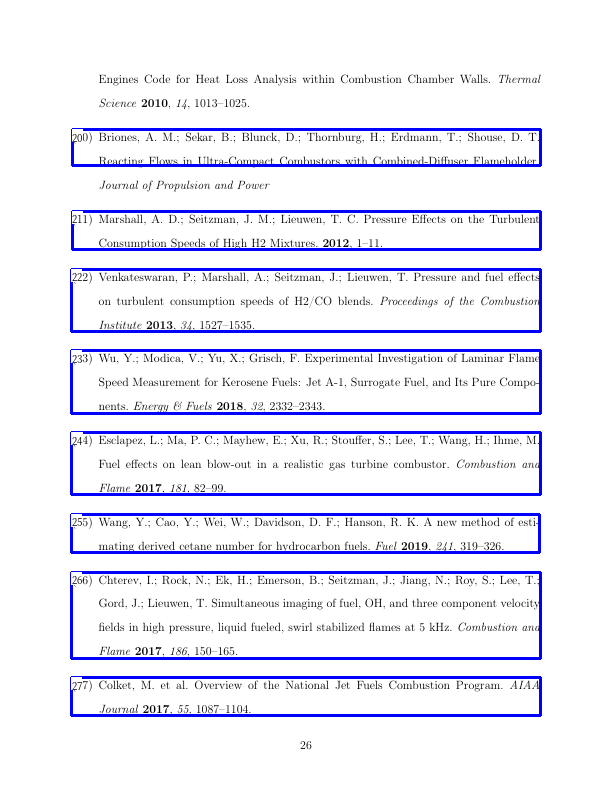

page 26:


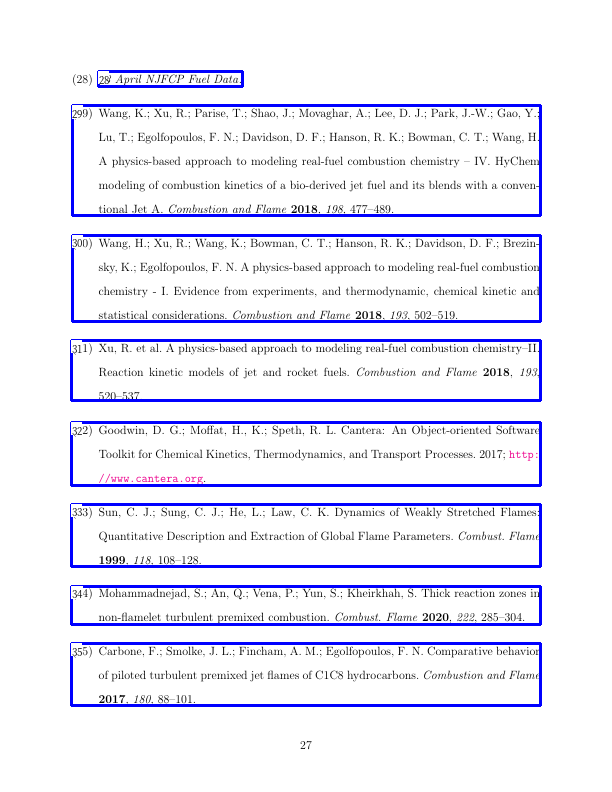

page 27:


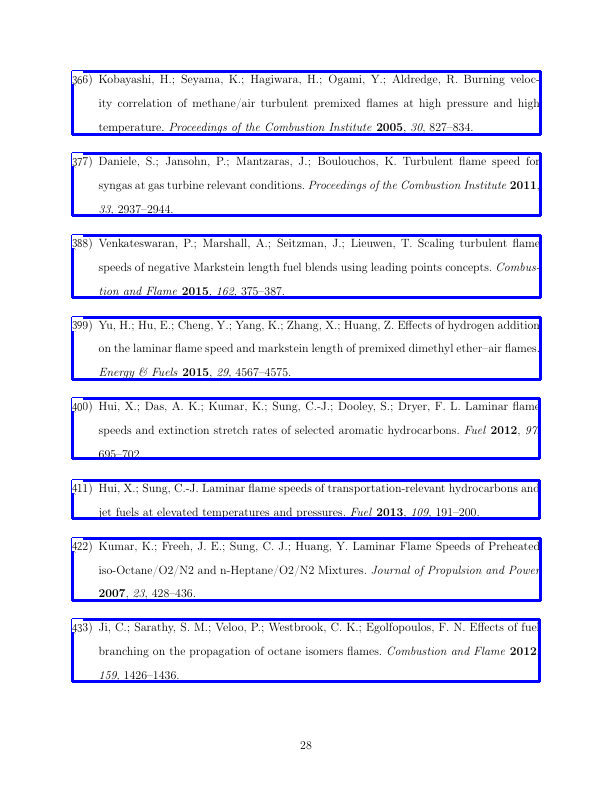

page 28:


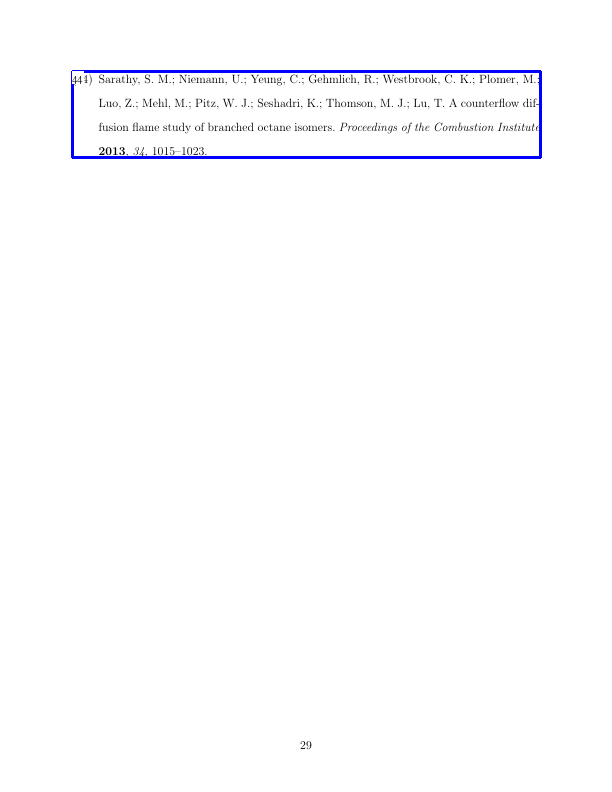

In [16]:
# bibs imgs
bib_pages = set([bib_entry.box_group.boxes[0].page for bib_entry in mmda_doc.bib_entries])

rows = len(bib_pages)
columns = 2
fontsize = 48

#spp
#make bib text blocks and save as image
print("SPP")

dic_text_blocks = make_text_blocks_bibs(mmda_doc)
bib_pages = sorted(list(bib_pages))
print('bib_pages', bib_pages)
for page in bib_pages:
    print(f"page {page}:")
    display(draw_text_blocks(page, dic_text_blocks))


## ANNOTATOR TODO: 
Record each mention on this page (regardless of if it got recognized by SPP or not) as 1 row in the spreadsheet.